# Channel Registration

The restored pictures are available at `./outputs` as well as the detected color channel of each picture

In [43]:
import cv2 as cv
import numpy as np
import os
import itertools
import matplotlib.pyplot as plt

In [ ]:
path = "./inputs"

images_path = os.listdir(path)

images = []

for image_path in images_path:
    
    image = cv.imread(os.path.join(path, image_path))

    if image is not None:

        print(f"{image_path} size: {image[:,:,0].shape}")

        # Saving Blue channel as the grayscale image
        images.append(image[:, :, 0])

    else:
        print(f"Failed to load {image_path}")

cathedral.jpg size: (1024, 390)
emir.jpg size: (2280, 876)


### Cropping Images


In [7]:
white_threshold = 250
black_threshold = 30

images_channels = []

for i, image in enumerate(images):

    height, width = image.shape

    white_mask = ((image >= white_threshold) * 255).astype(np.uint8)
    black_mask = ((image <= black_threshold) * 255).astype(np.uint8)
    

    row_sums = np.sum(black_mask.astype(np.int32), axis=1)
    row_sums_diff = row_sums[1:] - row_sums[:-1]
 
    sorted_idx = np.argsort(row_sums_diff)
    top_border = (sorted_idx[sorted_idx < 0.2 * height])[0]
    bottom_border = (sorted_idx[sorted_idx > 0.8 * height])[-1]

    cropped_image = image[top_border:bottom_border, :]
    cropped_black_mask = black_mask[top_border:bottom_border, :]

    row_sums = np.sum(cropped_black_mask, axis=1) / 255
    cropped_black_mask[row_sums < 0.6 * width] = 0

    image_channels = []
    start_row = 0

    row_sums = np.sum(cropped_black_mask, axis=1)

    for row_index, row_sum in enumerate(row_sums):
        if row_sum > 0:
            if row_index != start_row:
                image_channels.append(cropped_image[start_row:row_index])

                print(f"Appending rows {start_row} : {row_index} as a pic")

            start_row = row_index + 1

    image_channels.append(cropped_image[start_row:])

    if len(image_channels) > 3:
        image_channels = sorted(image_channels, key=lambda x: x.shape)[-3:]

    print()
    print(image_channels[0].shape)
    print(image_channels[1].shape)
    print(image_channels[2].shape)
    print()
    
    images_channels.append(image_channels)

    for j in range(3):
        cv.imshow("pic", images_channels[i][j])
        cv.waitKey(0)
        cv.destroyAllWindows()

Appending rows 0 : 325 as a pic
Appending rows 326 : 664 as a pic
Appending rows 665 : 666 as a pic

(325, 390)
(327, 390)
(338, 390)

Appending rows 0 : 720 as a pic
Appending rows 729 : 1476 as a pic

(720, 876)
(747, 876)
(709, 876)



### Aligning and Resizing the channels of each image

In [8]:
# Resizing all channels
for image_channels in images_channels:
    # Selecting the largest picture as the main channel
    largest_channel = max(image_channels, key=lambda x: x.shape)
    max_height = largest_channel.shape[0]

    crop_width = int(largest_channel.shape[1] * 0.6)
    left = (width - crop_width) // 2
    right = left + crop_width
    sample_image = largest_channel[:, left:right]

    edges = cv.Canny(sample_image, 100, 200)  # Applying Canny edge detection
    _, sample_edge = cv.threshold(edges, 128, 255, cv.THRESH_BINARY)

    # Finding the best Padding needed for each channel to align all channels properly on top of each other
    for i, channel in enumerate(image_channels):
        if channel.shape[0] < max_height:
            
            height_diff = max_height - channel.shape[0]

            temp_image = channel[:, left:right]
            edges = cv.Canny(temp_image, 100, 200)  # Applying Canny edge detection
            _, temp_edge = cv.threshold(edges, 128, 255, cv.THRESH_BINARY)

            best_offset = 0
            min_error = np.inf

            for offset in range(height_diff):
                top = offset
                bottom = -(height_diff - offset)

                # Calculating Image Difference for selected channel and the main channel
                diff = cv.absdiff(sample_edge[top:bottom, :], temp_edge)

                if np.sum(diff) < min_error:
                    best_offset = offset
                    min_error = np.sum(diff)

            # Adding padding to the selected channel in order to create 3 equally sized channels
            image_channels[i] = cv.copyMakeBorder(
                channel,
                top=best_offset,
                bottom=height_diff - best_offset,
                left=0,
                right=0,
                borderType=cv.BORDER_REFLECT,
            )

### Merging each image's channels to achieve colored image

Image saved!


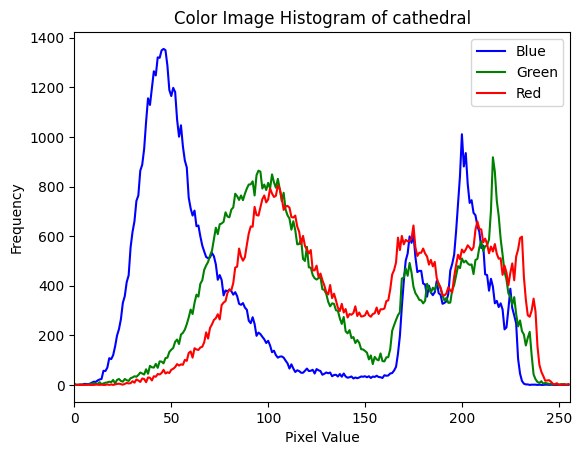

Image saved!


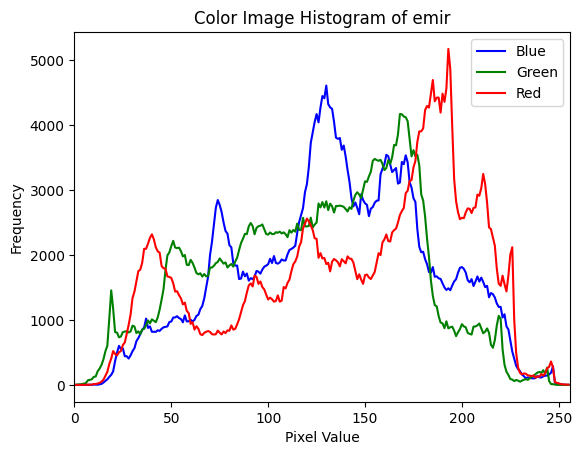

In [ ]:
for i, image_channels in enumerate(images_channels):
    height, width = image_channels[0].shape

    # Numbers to permute
    numbers = [0, 1, 2]
    
    statistic_perm = [-1, -1, -1]   # * [B, G, R]
    
    # Cropping borders to calculate more accurate histogram
    crop_percent = 0.1  # 10% crop from each side
    crop_height = int(height * crop_percent)
    crop_width = int(width * crop_percent)
    cropped_channels = [image_channels[idx][crop_height:-crop_height, crop_width:-crop_width] for idx in range(3)]

    # Split the image into its color channels
    ch1, ch2, ch3 = [image_channels[idx] for idx in range(3)]

    # Calculate histograms for each color channel
    hist_1 = cv.calcHist([ch1], [0], None, [256], [0, 256])
    hist_2 = cv.calcHist([ch2], [0], None, [256], [0, 256])
    hist_3 = cv.calcHist([ch3], [0], None, [256], [0, 256])
    
    hists = [hist_1, hist_2, hist_3]
    
    
    # channel with higher peak of count in lower intensities is usually red
    statistic_perm[0] = np.argmin([np.argmin(np.argmax([hists[idx]])) for idx in range(3)])
    
    # channel with higher pixel count in high intesities is usually red
    statistic_perm[2] = np.argmax([np.sum(hists[idx][128:]) for idx in range(3)])
    
    # the only left channel belongs to green
    statistic_perm[1] = 3 - np.sum(statistic_perm) - 1


    final_image = np.concatenate(
            (
                image_channels[statistic_perm[0]][..., np.newaxis],
                image_channels[statistic_perm[1]][..., np.newaxis],
                image_channels[statistic_perm[2]][..., np.newaxis],
            ),
            axis=2,
        )
    image_name = images_path[i].split(sep='.')[0]
    
    cv.imshow(f"{image_name}", final_image)
    file_name = f"{image_name}_colored.png"
    b_name = f"{image_name}_Blue.png"
    g_name = f"{image_name}_Green.png"
    r_name = f"{image_name}_Red.png"
    
    cv.imwrite(f"./outputs/{file_name}", final_image)
    cv.imwrite(f"./outputs/{b_name}", final_image[:,:,0])
    cv.imwrite(f"./outputs/{g_name}", final_image[:,:,1])
    cv.imwrite(f"./outputs/{r_name}", final_image[:,:,2])

    print("Image saved!")
    cv.waitKey(0)
    cv.destroyAllWindows()

    # Splitting the image into its color channels
    b, g, r = cv.split(final_image[crop_height:-crop_height, crop_width:-crop_width])

    # Calculating histograms for each color channel
    hist_b = cv.calcHist([b], [0], None, [256], [0, 256])
    hist_g = cv.calcHist([g], [0], None, [256], [0, 256])
    hist_r = cv.calcHist([r], [0], None, [256], [0, 256])


    # Plotting histograms
    plt.figure()
    plt.title(f"Color Image Histogram of {image_name}")
    plt.xlabel("Pixel Value")
    plt.ylabel("Frequency")
    plt.plot(hist_b, color='blue', label='Blue')
    plt.plot(hist_g, color='green', label='Green')
    plt.plot(hist_r, color='red', label='Red')
    plt.xlim([0, 256])
    plt.legend()
    plt.show()

